# Figure 4: Classifier two-sample test basic visualization

In [ ]:
import torch
import numpy as np
from torch import ones, zeros, float32, as_tensor, tensor, eye, sum, Tensor, manual_seed
from torch.distributions import MultivariateNormal, Normal, Categorical
from typing import Any
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from labproject.data import toy_mog_2d

## 1-d densities and optimal classification

We plot two different univariate Gaussian distributions. The optimal classifier takes the central gray line as the decision boundary, resulting in the shaded misclassified regions but still guaranteeing a classification accuracy over 50%.

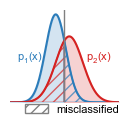

In [ ]:
x = np.arange(-7.74, 8.26, 0.01)
gaussian = lambda x, mu=0.0, std=1.0: np.exp(-0.5 * ((x - mu) / std) ** 2) / std / np.sqrt(2 * np.pi)
with mpl.rc_context(fname="matplotlibrc"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(1.4, 1.2))
    # plot pdfs
    plt.plot(x, gaussian(x, mu=-1.0, std=1.5), color="#2b7cba")
    plt.plot(x, gaussian(x, mu=1.0, std=2.0), color="#d52221")
    # shade classification areas
    plt.fill_between(x[:len(x) // 2], gaussian(x[:len(x) // 2], mu=-1.0, std=1.5), color="#2b7cba", alpha=0.2)
    plt.fill_between(x[len(x) // 2:], gaussian(x[len(x) // 2:], mu=1.0, std=2.0), color="#d52221", alpha=0.2)
    # hatch misclassified areas
    plt.fill_between(x[:len(x) // 2], gaussian(x[:len(x) // 2], mu=1.0, std=2.0), color="#d52221", facecolor="none", alpha=0.7, hatch="///")
    plt.fill_between(x[len(x) // 2:], gaussian(x[len(x) // 2:], mu=-1.0, std=1.5), color="#2b7cba", facecolor="none", alpha=0.7, hatch="///")
    # bounds
    plt.ylim(0)
    plt.xlim(-7.74, 8.26)
    plt.axvline(0.26, color='grey', linewidth=1.0)
    # labels
    plt.text(-6.7, 0.125, "$p_1(x)$", color="#2b7cba")
    plt.text(3.4, 0.125, "$p_2(x)$", color="#d52221")
    # clean axes
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    # legend
    legend_elements = [mpl.patches.Patch(facecolor='none', edgecolor='gray', hatch='///',
                         label='misclassified')]
    plt.legend(handles=legend_elements, handleheight=0.8, loc=(0.10, -0.18))
    plt.savefig("svg/fig1_panel_a.svg", bbox_inches="tight")
    plt.show()

## Classifier problem and training depiction

We plot samples from a multivariate Gaussian and a mixture of Gaussians to depict the training task of the classifier.

In [ ]:
# generate samples from mixture to compute single-gaussian approximation
n_samples = 5000
toy = toy_mog_2d()
samples_mog = toy.sample((n_samples,))
samples_np = samples_mog.numpy()
samples_normal_approx = Normal(samples_mog.mean(dim=0), samples_mog.std(dim=0)).sample((n_samples,)).numpy()

# subselect samples to plot and prepare plot params
n_plot = 10
samples_to_plot = samples_np[0:10,:]

al=0.4
ms=6
mec='k'

densities = [samples_np, samples_normal_approx]
samples_plot = [samples_np[:20], samples_normal_approx[:20]]
titles = [r'$p_{true}(x)$', r'$p_{1}(x)$']
cmaps = ['Blues', 'Reds']

<ipython-input-9-06f4992e5502>:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout(pad=4.0, w_pad=1)


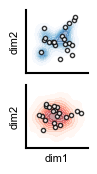

In [ ]:
# plot densities and samples
with mpl.rc_context(fname="matplotlibrc"):
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(0.8, 1.8))
    for i_a, ax in enumerate(axs):
        density, samples, cmap, title = densities[i_a], samples_plot[i_a], cmaps[i_a], titles[i_a]
        sns.kdeplot(x=density[:,0], y=density[:,1], fill=True, thresh=0.05, levels=10, cmap=cmap, ax=ax, alpha=al)
        ax.plot(samples[:, 0], samples[:, 1], 'w.', ms=ms, mec=mec, alpha=0.8)
        ax.set_xticks([]); ax.set_yticks([])
        # ttl = ax.set_title(title, fontsize=12);
        ax.set_xlim([-7,4]); ax.set_ylim([-6,4])

    for i in range(2):
        axs[i].set_ylabel('dim2')
    axs[1].set_xlabel('dim1')

    fig.tight_layout(pad=4.0, w_pad=1)
    plt.savefig("svg/fig1_panel_b1.svg", bbox_inches="tight")
    plt.show()

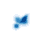

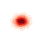

In [ ]:
# plot densities again in small as target classes
with mpl.rc_context(fname="matplotlibrc"):
    for i in range(2):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(0.3, 0.3))
        density, cmap = densities[i], cmaps[i]
        sns.kdeplot(x=density[:,0], y=density[:,1], fill=True, thresh=0.05, levels=10, cmap=cmap, ax=ax, alpha=1.0)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlim([-7,4]); ax.set_ylim([-6,4])
        _ = ax.spines["left"].set_visible(False)
        _ = ax.spines["bottom"].set_visible(False)

        plt.savefig(f"svg/fig1_panel_b2_{i}.svg", bbox_inches="tight", transparent=True)
        plt.show()

## Intuition on C2ST score interpretation

### C2ST = 0.5

C2ST = 0.5 when the distributions are not distinguishable by the classifier.

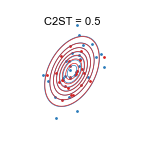

In [ ]:
np.random.seed(0)
from scipy.stats import multivariate_normal
rv1 = multivariate_normal([0.0, 0.0], [[0.6, 0.3], [0.3, 1.0]])
rv2 = multivariate_normal([0.0, 0.0], [[0.57, 0.285], [0.285, 0.95]])
x, y = np.meshgrid(
    np.linspace(-3.5, 3.5, 1000),
    np.linspace(-3.5, 3.5, 1000),
)
pos = np.dstack((x, y))
with mpl.rc_context(fname="matplotlibrc"):
    fig = plt.figure(figsize=(1.6, 1.6))
    plt.contour(x, y, rv1.pdf(pos), colors='#2b7cba', linewidths=0.5)
    plt.contour(x, y, rv2.pdf(pos), colors='#d52221', linewidths=0.5)
    plt.scatter(*rv1.rvs(size=25).T, color='#2b7cba', s=1.0)
    plt.scatter(*rv2.rvs(size=25).T, color='#d52221', s=1.0)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.text(0.0, 2.8, "C2ST = 0.5", ha='center', va='center')
    plt.savefig("svg/fig1_panel_c1.svg", bbox_inches="tight", transparent=True)
    plt.show()

### C2ST = 0.7

C2ST is around 0.7 or 0.8 when the distributions are distinguishable but still overlapping.

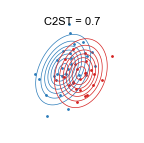

In [ ]:
np.random.seed(0)
rv1 = multivariate_normal([-0.5, 0.1], [[0.6, 0.3], [0.3, 1.0]])
rv2 = multivariate_normal([0.5, -0.1], [[0.55, 0.15], [0.15, 0.95]])
x, y = np.meshgrid(
    np.linspace(-3.5, 3.5, 1000),
    np.linspace(-3.5, 3.5, 1000),
)
pos = np.dstack((x, y))
with mpl.rc_context(fname="matplotlibrc"):
    fig = plt.figure(figsize=(1.6, 1.6))
    plt.contour(x, y, rv1.pdf(pos), colors='#2b7cba', linewidths=0.5)
    plt.contour(x, y, rv2.pdf(pos), colors='#d52221', linewidths=0.5)
    plt.scatter(*rv1.rvs(size=25).T, color='#2b7cba', s=1.0)
    plt.scatter(*rv2.rvs(size=25).T, color='#d52221', s=1.0)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.text(0.0, 2.8, "C2ST = 0.7", ha='center', va='center')
    plt.savefig("svg/fig1_panel_c2.svg", bbox_inches="tight", transparent=True)
    plt.show()

### C2ST = 1.0

C2ST is 1.0 when the two distributions are completely non-overlapping and the classifier can classify every sample correctly.

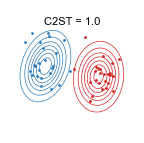

In [ ]:
np.random.seed(1)
rv1 = multivariate_normal([-1.5, 0.3], [[0.5, 0.2], [0.2, 1.0]])
rv2 = multivariate_normal([1.5, -0.3], [[0.5, 0.05], [0.05, 1.0]])
x, y = np.meshgrid(
    np.linspace(-3.5, 3.5, 1000),
    np.linspace(-3.5, 3.5, 1000),
)
pos = np.dstack((x, y))
with mpl.rc_context(fname="matplotlibrc"):
    fig = plt.figure(figsize=(1.6, 1.6))
    plt.contour(x, y, rv1.pdf(pos), colors='#2b7cba', linewidths=0.5)
    plt.contour(x, y, rv2.pdf(pos), colors='#d52221', linewidths=0.5)
    plt.scatter(*rv1.rvs(size=25).T, color='#2b7cba', s=1.0)
    plt.scatter(*rv2.rvs(size=25).T, color='#d52221', s=1.0)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.text(0.0, 2.8, "C2ST = 1.0", ha='center', va='center')
    plt.savefig("svg/fig1_panel_c3.svg", bbox_inches="tight", transparent=True)
    plt.show()

## Construct figure with svgutils

In [ ]:
import time
from svgutils.compose import *
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_caption = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_text = {'size': '7.75pt', 'font': 'Arial'}

f = Figure(
    "16.6cm",
    "4.2cm",
    Panel(SVG("svg/fig1_panel_a.svg").scale(svg_scale).move(5, 15), Text("a", 0, 25.0, **kwargs_caption).move(10, -10)),
    Panel(SVG("svg/fig1_panel_b1.svg").scale(svg_scale).move(10, 5), Text("b", 0, 25.0, **kwargs_caption)).move(130, -10),
    Panel(SVG("svg/fig1_illustration.svg").scale(1.5).move(10, 5)).move(220, 20),
    Panel(Text("?", 0, 25.0, **kwargs_text)).move(338, 49),
    Panel(SVG("svg/fig1_panel_b2_0.svg")).move(315, 49),
    Panel(SVG("svg/fig1_panel_b2_1.svg")).move(315, 61),
    Panel(SVG("svg/fig1_panel_c1.svg").scale(svg_scale).move(10, 15), Text("c", 20, 25.0, **kwargs_caption).move(10, -10)).move(320, 0),
    Panel(SVG("svg/fig1_panel_c2.svg").scale(svg_scale).move(10, 15)).move(405, 0),
    Panel(SVG("svg/fig1_panel_c3.svg").scale(svg_scale).move(10, 15)).move(500, 0),
)

f.save("fig/fig1.svg")
svg("fig/fig1.svg")